# Dask Diagnostic Tools

In this notebook we demonstrate a few diagnostic tools to examine the code execution and performance. 

* Visualize task graphs
* Local diagnostics tools
* Distributed diagnostics tools
---

- Authors: NCI Virtual Research Environment Team
- Keywords: Dask, Diagnostics
- Creation Date: 2020-June
- Lineage/Reference: This tutorial is developed based on [Dask documentation](https://docs.dask.org/en/latest/understanding-performance.html).
---

## Dask offers code profiling tools

The first step in making computations more run quickly is to understand the costs involved. The Dask schedulers come with diagnostics to help you understand the performance characteristics of your computations. By using these diagnostics and with some thought, it may be possible to identify the slow parts of troublesome computations.

### Visualise task graphs

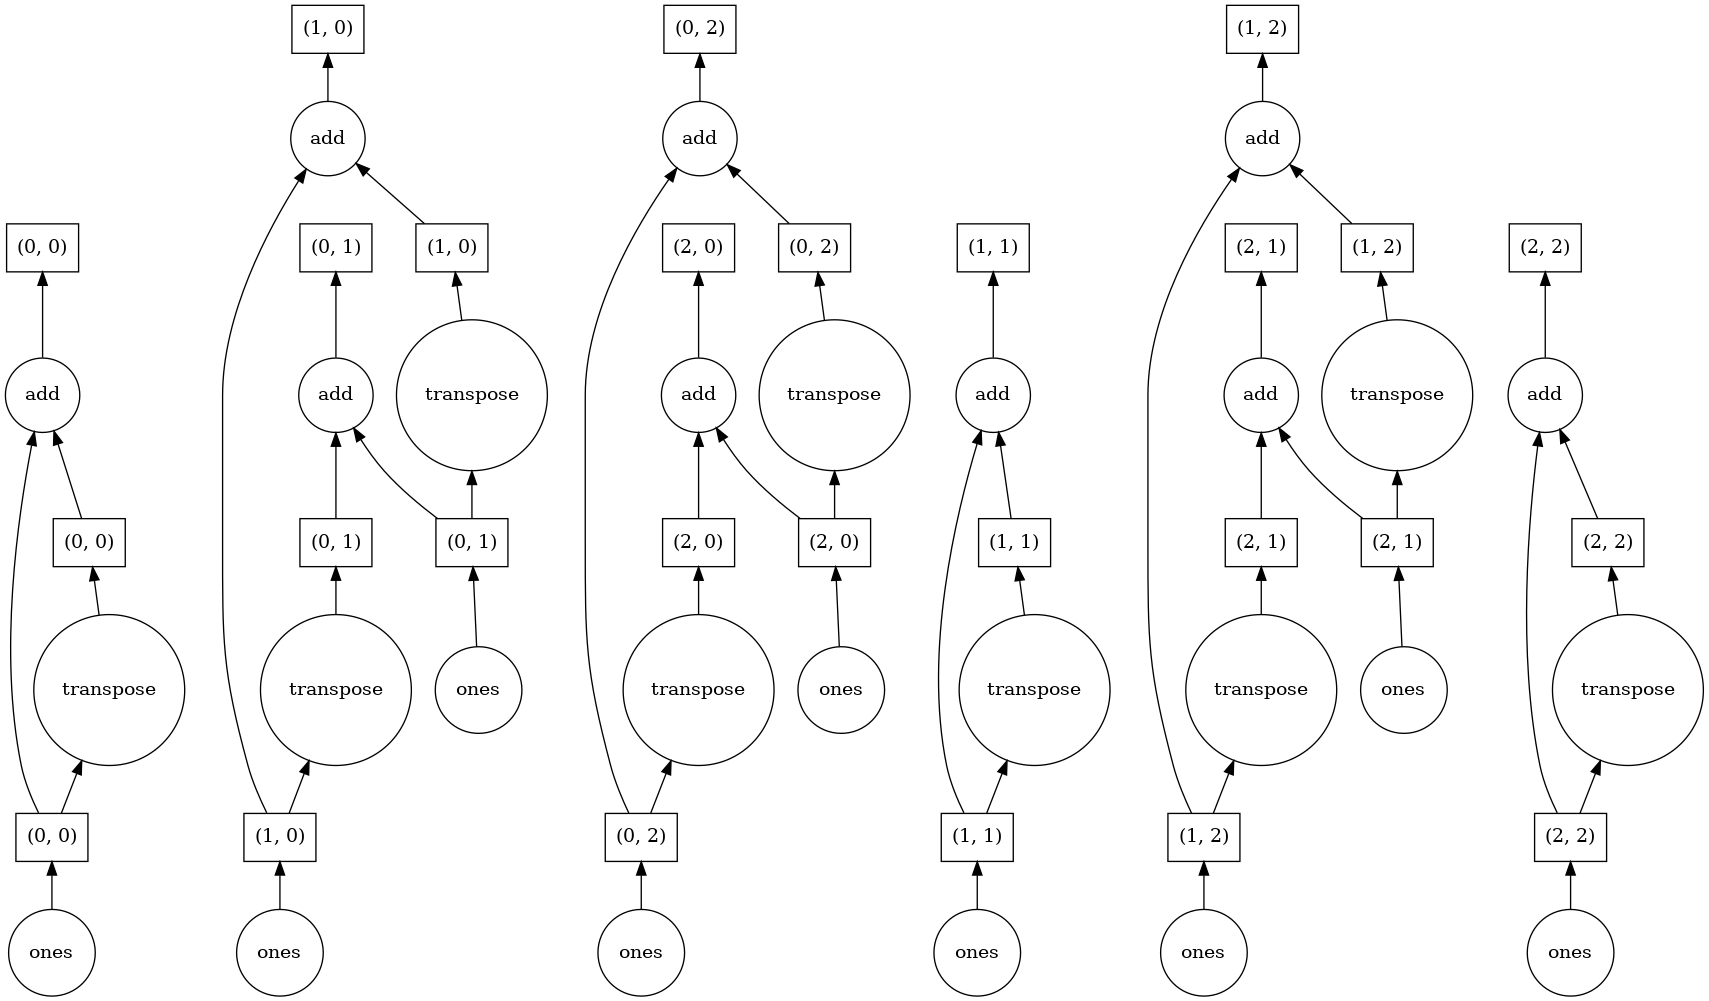

In [1]:
import dask.array as da
import graphviz
x = da.ones((15,15), chunks=(5,5))
y = x + x.T
y.visualize()

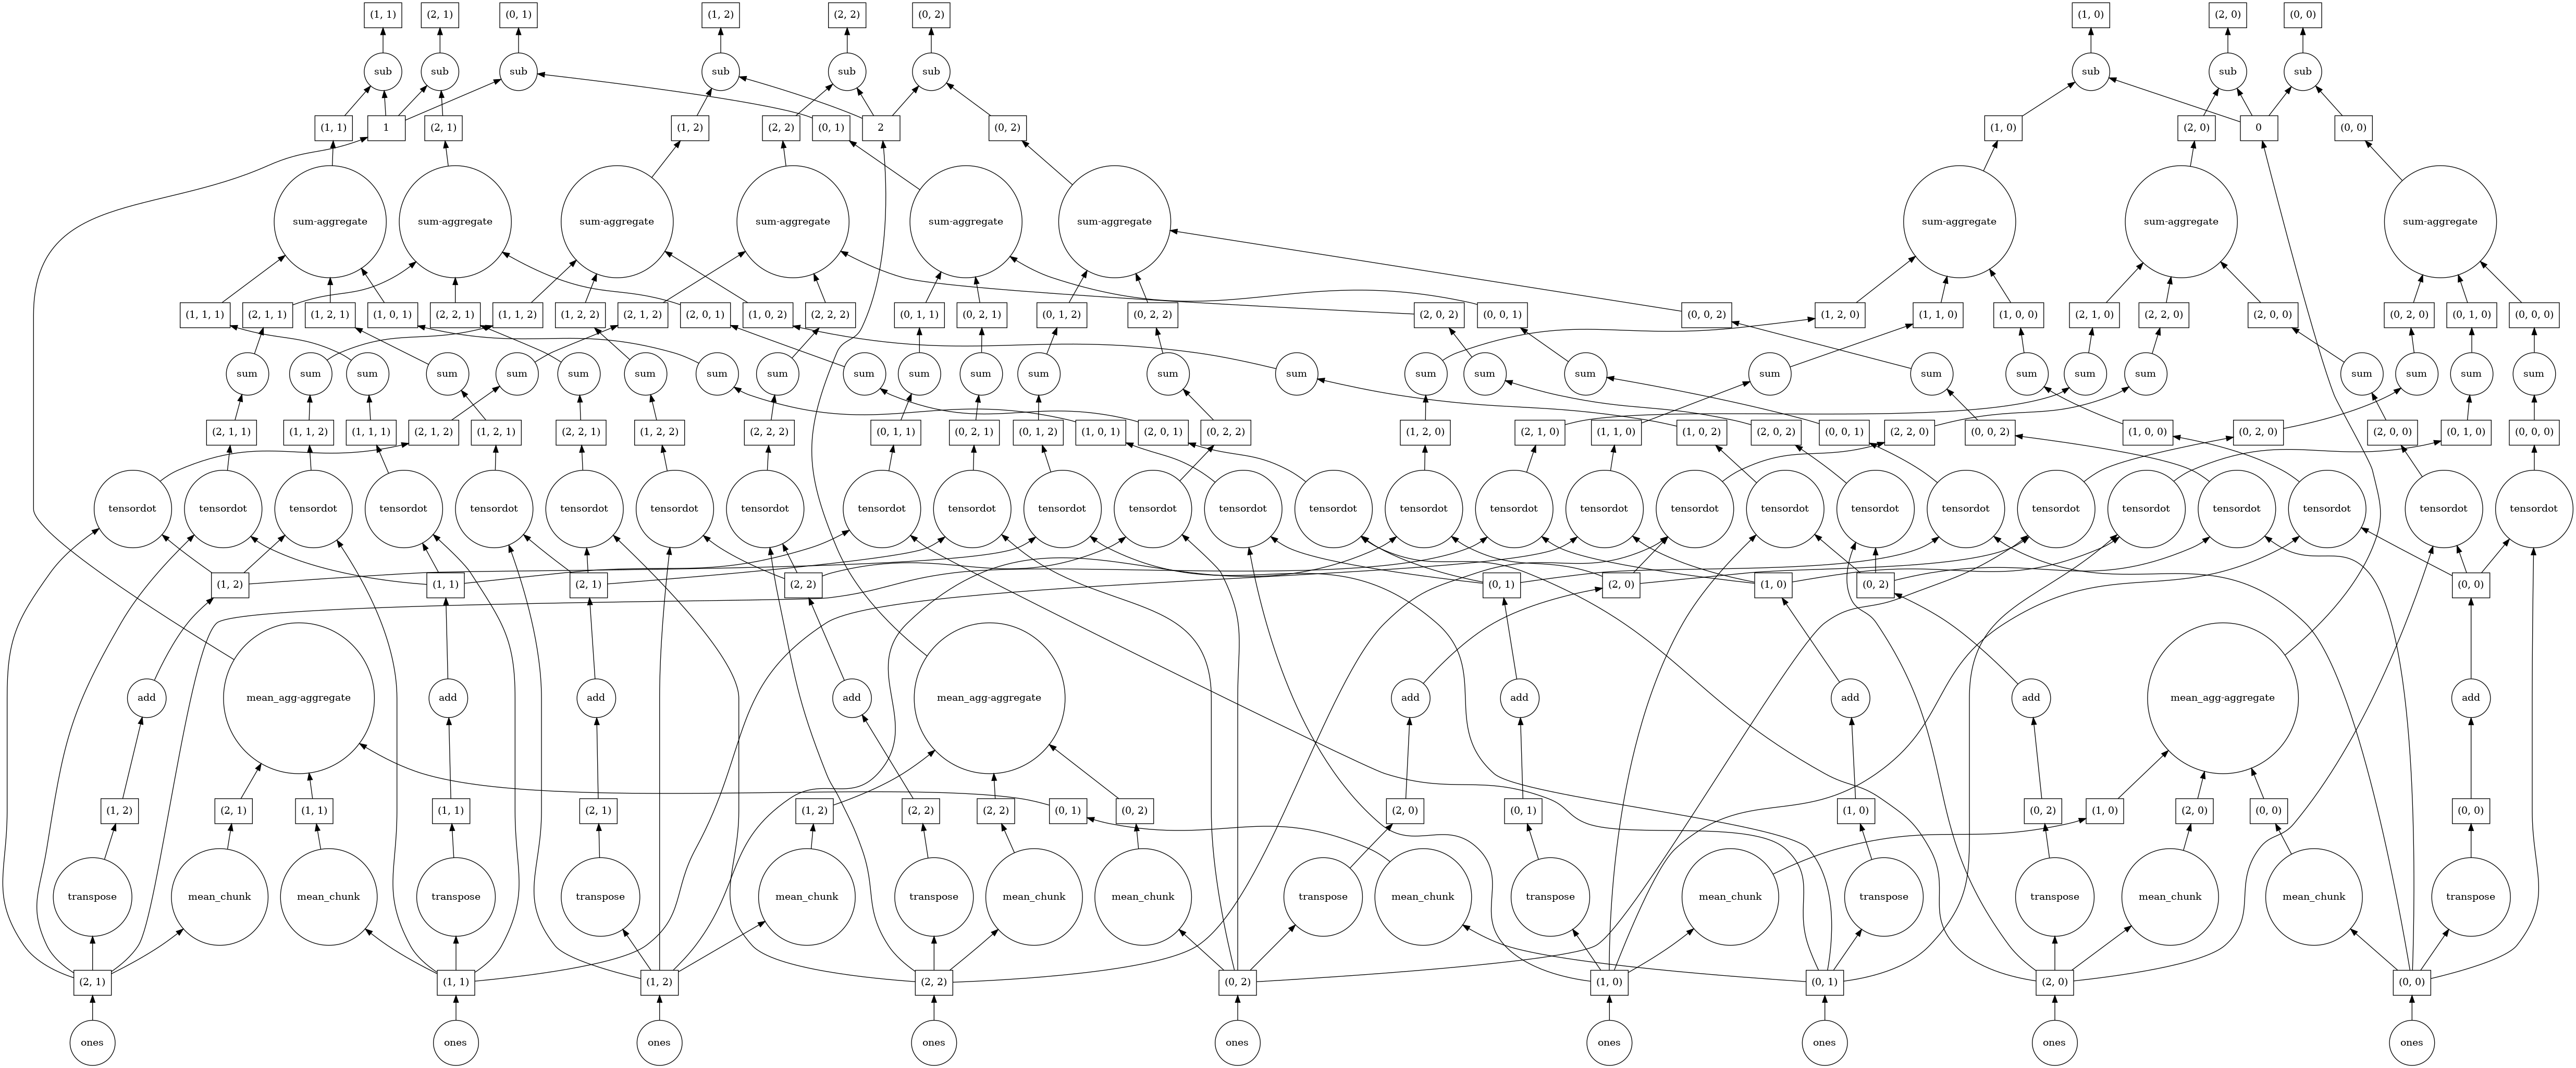

In [2]:
z = x.dot(x.T + 1) - x.mean(axis=0)
z.visualize()

### Diagnostics (local)

`Dask.diagnostics` provides functionality to aid in profiling and inspecting execution with the local task scheduler.

This notebook describes the following built-in options:

- ProgressBar
- Profiler
- ResourceProfiler
- CacheProfiler

#### Progress Bar

The `ProgressBar` class builds on the scheduler callbacks described above to display a progress bar in the terminal or notebook during computation. This can provide useful feedback during long running graph executions. It can be used as a context manager around calls to `get` or `compute` to profile the computation:

In [3]:
from dask.diagnostics import ProgressBar
a = da.random.normal(size=(10000, 10000), chunks=(5000, 5000))
res = a.dot(a.T).mean(axis=0)

with ProgressBar():
    out = res.compute()

[########################################] | 100% Completed |  4.5s


or registered globally using the `register` method:

In [4]:
pbar = ProgressBar()
pbar.register()
out = res.compute()

[########################################] | 100% Completed |  4.5s


To unregister from the global callbacks, call the `unregister` method:

In [5]:
pbar.unregister()

#### Profiler - A profiler for task excution at task level

Dask provides a few tools for profiling execution. As with the `ProgressBar`, they can be used as context managers or registered globally.

The `Profiler` class is used to profile Dask’s execution at the task level. During execution, it records the following information for each task:

1. Key
2. Task
3. Start time in seconds since the epoch
4. Finish time in seconds since the epoch
5. Worker id


#### ResourceProfiler - A profile for resource use

The `ResourceProfiler` class is used to profile Dask’s execution at the resource level. During execution, it records the following information for each timestep:

1. Time in seconds since the epoch
2. Memory usage in MB
3. % CPU usage

#### CacheProfiler - A profiler for dask execution at the scheduler cache level.

The `CacheProfiler` class is used to profile Dask’s execution at the scheduler cache level. During execution, it records the following information for each task:

1. Key
2. Task
3. Size metric
4. Cache entry time in seconds since the epoch
5. Cache exit time in seconds since the epoch

### Example

As an example to demonstrate using the diagnostics, we’ll profile some arithmetic operation on CMIP6 datasets. Note that since the profilers (and all diagnostics) are just context managers, multiple profilers can be used in a `with` block:

In [11]:
import xarray as xr
EnsNum=2
DS=[]
for i in range(1,EnsNum+1): #loop through ensemble members
    #concatenate data on time coordinate
    data=xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r'+str(i)+'i1p1f1/day/pr/gn/v*/pr_day_ACCESS-CM2_historical_r'+str(i)+'i1p1f1_gn_*.nc',combine='nested', concat_dim='time' )
    DS.append(data)
ds=xr.concat([DS[i] for i in range(EnsNum)],'ensemble')
pr_mean = ds['pr'].mean(dim='time')
spread = (pr_mean.max(dim='ensemble')
        - pr_mean.min(dim='ensemble'))

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    spread = spread.persist()

The results of each profiler are stored in their `results` attribute as a list of `namedtuple` objects, for example:

In [12]:
prof.results[0]

TaskData(key=('open_dataset-concatenate-c65d8386de0ea7038d3d5fb40e42f881', 1, 0, 0), task=(<function getter at 0x14e6da3699e0>, 'open_dataset-26c4b7917d36c627f6ea343aad0f926dpr-b583f940d850da0c1bacab6df08a7bda', (slice(0, 18262, None), slice(0, 144, None), slice(0, 192, None))), start_time=1480991.809835322, end_time=1481015.591533548, worker_id=22981113710336)

In [13]:
rprof.results[0]

ResourceData(time=1480991.844693699, mem=1462.734848, cpu=0.0)

These can be analysed separately or viewed in a Bokeh plot using the provided `visualize` method on each profiler:

In [14]:
cprof.results[0]

CacheData(key=('open_dataset-concatenate-c65d8386de0ea7038d3d5fb40e42f881', 0, 0, 0), task=(<function getter at 0x14e6da3699e0>, 'open_dataset-fe3145e44607a9dd25a31deee90153f8pr-8ca9743603ba551c02b303139e8b1835', (slice(0, 18262, None), slice(0, 144, None), slice(0, 192, None))), metric=1, cache_time=1481004.275087605, free_time=1481004.275657363)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
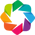

In [15]:
%matplotlib inline
import holoviews as hv
import datashader
hv.extension('bokeh', width=100)

In [16]:
prof.visualize()

Figure(id='1001', ...)

To view multiple profilers at the same time, the `dask.diagnostics.visualize` function can be used. This takes a list of profilers and creates a vertical stack of plots aligned along the x-axis:

In [17]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='1336', ...)

Looking at the above figure, from top to bottom:

1. The results from the `Profiler` object: This shows the execution time for each task as a rectangle, organized along the y-axis by worker (in this case threads). Similar tasks are grouped by color and, by hovering over each task, one can see the key and task that each block represents.

2. The results from the `ResourceProfiler` object: This shows two lines, one for total CPU percentage used by all the workers, and one for total memory usage.

3. The results from the `CacheProfiler` object: This shows a line for each task group, plotting the sum of the current `metric` in the cache against time. In this case it’s the default metric (count) and the lines represent the number of each object in the cache at that time. Note that the grouping and coloring is the same as for the `Profiler` plot, and that the task represented by each line can be found by hovering over the line.

### Diagnostics (distributed)

The Dask distributed scheduler provides live feedback in two forms:

1. An interactive dashboard containing many plots and tables with live information
2. A progress bar suitable for interactive use in consoles or notebooks

If Bokeh is installed then the dashboard will start up automatically whenever the scheduler is created. For local use this happens when you create a client with no arguments:

In [21]:
from dask.distributed import Client
client = Client()

/apps/pangeo/2020.05/lib/python3.7/site-packages/distributed/node.py:244: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42235 instead
  http_address["port"], self.http_server.port


It is typically served at http://localhost:8787/status, but may be served elsewhere if this port is taken.

If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file. Please make sure you specify the correct path to the scheduler.json file within your environment. If you run this notebook under Pangeo environment on Gadi, the port number is assigned by the job submission and saved in the `client_cmd` file. The address of the dashboard will be displayed if you are in a Jupyter Notebook, or can be queried from `client.scheduler_info()['services']`.

In [ ]:
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='../scheduler.json')
print(client)

You can watch the [YouTube video](https://www.youtube.com/watch?v=N_GqzcuGLCY) below to get a full overview of what dashboard offers. There are a number of pages with information about task runtimes, communication, statistical profiling, load balancing, memory use, and much more.

<div class="alert alert-warning">
<b>Warning:</b> If you run this notebook on the Gadi compute node, you won't be able to see the video as Gadi compute nodes are not accessible to an external website.
</div>

In [ ]:
from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

display_yotube_video("https://www.youtube.com/watch?v=N_GqzcuGLCY", width=600, height=400)


You can capture some of the same information that the dashboard presents for offline processing using the `get_task_stream` and `Client.profile` functions. These capture the start and stop time of every task and transfer, as well as the results of a statistical profiler.

In [24]:
from dask.distributed import get_task_stream
with get_task_stream() as ts:
    x.compute()

history = ts.data

data, figure = client.get_task_stream(plot='save', filename='myfile.html')

In [25]:
client.profile(filename="dask-profile.html")

({'description': {'filename': '', 'name': '', 'line_number': 0, 'line': ''},
  'children': {},
  'count': 0,
  'identifier': 'root'},
 Figure(id='5358', ...))

Get back a Bokeh figure and optionally save to a file

In [26]:
ts.figure

Additionally, Dask can save many diagnostics dashboards at once including the task stream, worker profiles, bandwidths, etc. with the `performance_report` context manager:

In [ ]:
from dask.distributed import performance_report

with performance_report(filename="dask-report.html"):
    ## some dask computation

### Progress bar

The `dask.distributed` progress bar differs from the `ProgressBar` used for local diagnostics. The `progress` function takes a Dask object that is executing in the background:

In [29]:
# Single machine progress bar
from dask.diagnostics import ProgressBar

with ProgressBar():
    x.compute()

# Distributed scheduler ProgressBar

from dask.distributed import progress

x = x.persist()  # start computation in the background
progress(x)      # watch progress

x.compute()      # convert to final result when done if desired

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.

### The accessible port

The default port for the web interface is 8787. However, some clusters restrict the ports that are visible to the outside world. These ports may include the default port for the web interface, 8787. There are a few ways to handle this:

1. Open port `8787` to the outside world. Often this involves asking your cluster administrator.
2. Use a different port that is publicly accessible using the --`dashboard-address :8787` option on the `dask-scheduler` command.
3. Use fancier techniques, like port forwarding

If you create a distributed schedular from the Pangeo environment on Gadi, a random port number (8000-8999) for the dashboard will be assigned to you. See more information on the page about [setting up Pangeo environment on Gadi](https://nci-data-training.readthedocs.io/en/latest/_notebook/prep/Setup_Pangeo_environment_Gadi.html).

### Summary

This example shows some dask diagnostic tools to examine the runtime and resource usages. 